In [1]:
# Import das Bibliotecas
from dotenv import load_dotenv
import psycopg
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Executa a função para carregar as variáveis do arquivo .env no ambiente
load_dotenv()

True

In [3]:
# Conexão com o banco de dados
def get_db_connection():
    """Cria e retorna uma conexão com o banco de dados."""
    try:
        conn = psycopg.connect(
            host="localhost",
            dbname=os.getenv("DB_NAME"),
            user=os.getenv("DB_USER"),
            password=os.getenv("DB_PASSWORD"),
            port=os.getenv("DB_PORT")
        )
        return conn
    except Exception as e:
        print(f"Erro ao conectar ao banco de dados: {e}")
        raise e

In [4]:
# Função para converter os números para nomes dos meses
def converter_meses_para_portugues(df, coluna_mes='month'):
    """
    Converte uma coluna numérica de meses (1-12) para nomes em português.
    
    Args:
        df: DataFrame pandas.
        coluna_mes: Nome da coluna com os números dos meses.
    
    Returns:
        DataFrame com a coluna modificada e ordenada corretamente.
    """
    # Mapeamento número -> nome do mês
    meses_pt = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'
    }
    
    # Converte os números para nomes
    df[coluna_mes] = df[coluna_mes].map(meses_pt)
    
    # Garante a ordem cronológica
    ordem_meses = list(meses_pt.values())
    df[coluna_mes] = pd.Categorical(
        df[coluna_mes],
        categories=ordem_meses,
        ordered=True
    )
    
    return df.sort_values(coluna_mes)

In [5]:
def execute_query(query, conn, cursor, return_df = True):
    conn.rollback() # Reinicia a transação (caso tenha alguma transação que tenha dado errado)

    cursor.execute(query)

    # Pegando os dados da consulta
    result = cursor.fetchall()

    # Pegando os nomes das colunas
    columns = cursor.description

    # Colocando o nome das colunas 
    df = [{columns[index][0]: column for index, column in enumerate(value)} for value in result]

    # Transformando de DataFrame para fazer o gráfico
    return pd.DataFrame(df)

In [6]:
# Estabelecendo a conexão
conn = get_db_connection()

# Estabelecendo o cursor para executar consultas
cursor = conn.cursor()

* Série Temporal de Internações:
    - Gráfico de linha com o `case_count` ao longo do tempo `notification_date_id`

In [7]:

query = '''
        SELECT * FROM gold.mart_total_cases_monthly
''' 

df = execute_query(query, conn, cursor, True)

df = converter_meses_para_portugues(df)

In [8]:
# Criar o gráfico de barras com Plotly
fig = px.bar(df, 
             x='month', 
             y='sum',
             title='Número total de Casos por Mês',
             labels={'sum': 'Número Total de Casos', 'month': 'Mêses'},
             text='sum')  # Isso adiciona os valores nas barras

# Personalizar o layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    xaxis_tickangle=-45
)

# Mostrar o gráfico
fig.show()

In [9]:
# Gráfico de linha com Plotly
fig = px.line(df, 
              x='month', 
              y='sum',
              title='Evolução do Número de Casos por Mês',
              labels={'sum': 'Número Total de Casos', 'month': 'Mêses'},
              markers=True,
              text='sum')  # Adiciona marcadores em cada ponto

# Personalização do layout
fig.update_layout(
    width=1200,
    height=600,
    xaxis_tickangle=-45,
    hovermode="x unified"  # Mostra informações ao passar o mouse
)

# Personalizar a linha e marcadores
fig.update_traces(
    line=dict(width=3, color='#4B79CF'),
    marker=dict(size=10, color='#1F4E79'),
    text=df['sum'],  # Valores que aparecem nos marcadores
    textposition="top center"
)

# Adicionar os valores em cima de cada ponto
fig.update_traces(
    texttemplate='%{text:.0f}',
    textfont_size=12,
    showlegend=False
)

fig.show()

* Análise dos Fatores de Risco

* Gráfico de barras mostrando a prevalência de comorbidades
    - Utilizar `fact_health_cases`:
        - Utilizar coluna `required_icu`
        - Linkar com `dim_risk_factors`

In [10]:
query = '''
        SELECT * FROM gold.mart_total_cases_per_risk_factor
        '''

df = execute_query(query, conn, cursor, True)

In [11]:
# Lista de colunas a serem incluídas no melt (todas exceto 'total_cases')
colunas_para_melt = [col for col in df.columns if col != 'total_cases']

# Transformar o DataFrame para o formato longo, excluindo 'total_cases'
df_melted = df.melt(value_vars=colunas_para_melt, 
                    var_name='fator_risco', 
                    value_name='numero_total_casos').sort_values(by='numero_total_casos', ascending=False)


In [12]:
df_melted

,fator_risco,numero_total_casos
24,total_icu_cases,44206
2,total_cases_cardiovascular,42448
12,total_cases_diabetes,25172
3,icu_cases_with_cardiovascular,14938
14,total_cases_neurological,10618
16,total_cases_pneumopathy,10132
10,total_cases_asthma,8713
13,icu_cases_with_diabetes,8675
20,total_cases_kidney_disease,6293
18,total_cases_immunodeficiency,5558


In [13]:
# Criar o gráfico de barras com Plotly
fig = px.bar(df_melted, 
             x='fator_risco', 
             y='numero_total_casos',
             title='Número total de Casos por Mês',
             labels={'sum': 'Número Total de Casos', 'fator_risco': 'Fatores de Risco'},
             text='numero_total_casos')  # Isso adiciona os valores nas barras

# Personalizar o layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    xaxis_tickangle=-45
)

# Mostrar o gráfico
fig.show()

* Distribuição Demográfica dos Casos:
    - Distribuição dos casos por `age_group` e `gender`
    - Identificação da dos grupos mais vulneráveis

In [14]:
query = '''
        SELECT 
            pt.gender AS genero,
            pt.age_group AS faixa_etaria,
            SUM(hc.case_count) AS numero_total_casos
        FROM 
            gold.dim_patients AS PT
        INNER JOIN
            gold.fact_health_cases AS hc
        ON
            pt.patient_id = hc.patient_id
        WHERE 
            pt.gender != 'IGNORADO'
        GROUP BY
            1, 2
        ORDER BY
            pt.age_group
'''

df = execute_query(query, conn, cursor, True)

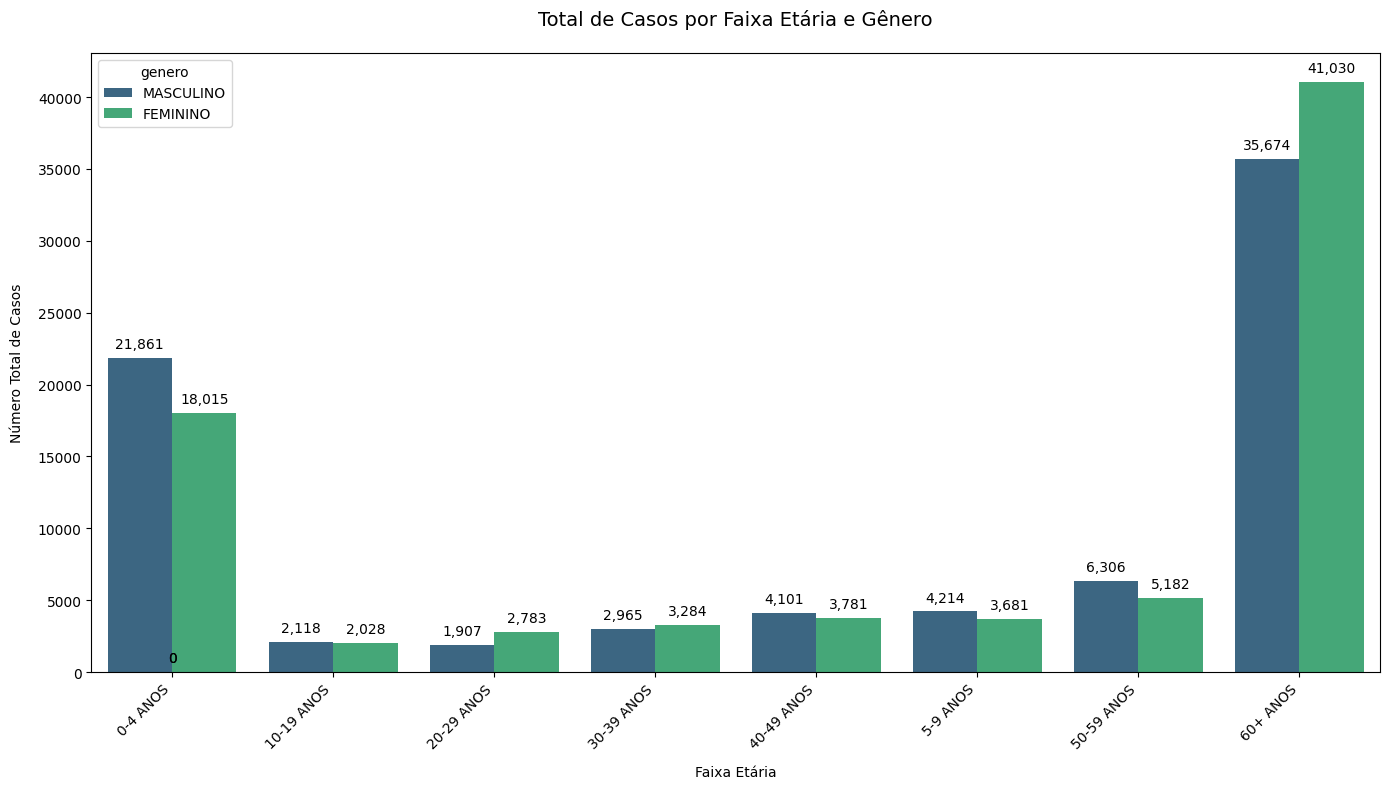

In [15]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, 
                x='faixa_etaria', 
                y='numero_total_casos',
                palette='viridis',
                hue='genero',
                errorbar=None)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Formata com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10,
                color='black')

# Melhorando a visualização
plt.title('Total de Casos por Faixa Etária e Gênero', pad=20, fontsize=14)
plt.xlabel('Faixa Etária', labelpad=10)
plt.ylabel('Número Total de Casos', labelpad=10)
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [16]:
query = '''
        SELECT 
            cc.final_classification AS srag,
            cc.case_outcome AS evolucao,
            SUM(hc.case_count) AS numero_total_casos
        FROM
            gold.dim_case_classifications AS cc
        INNER JOIN
            gold.fact_health_cases AS hc
        ON
            cc.case_classification_id = hc.case_classification_id
        GROUP BY
            1, 2
        ORDER BY
            1
'''

df = execute_query(query, conn, cursor, True)

Esse gráfico, talvez seja melhor, aparecer de acordo com o filtro especificado, ele geral fica muita informação

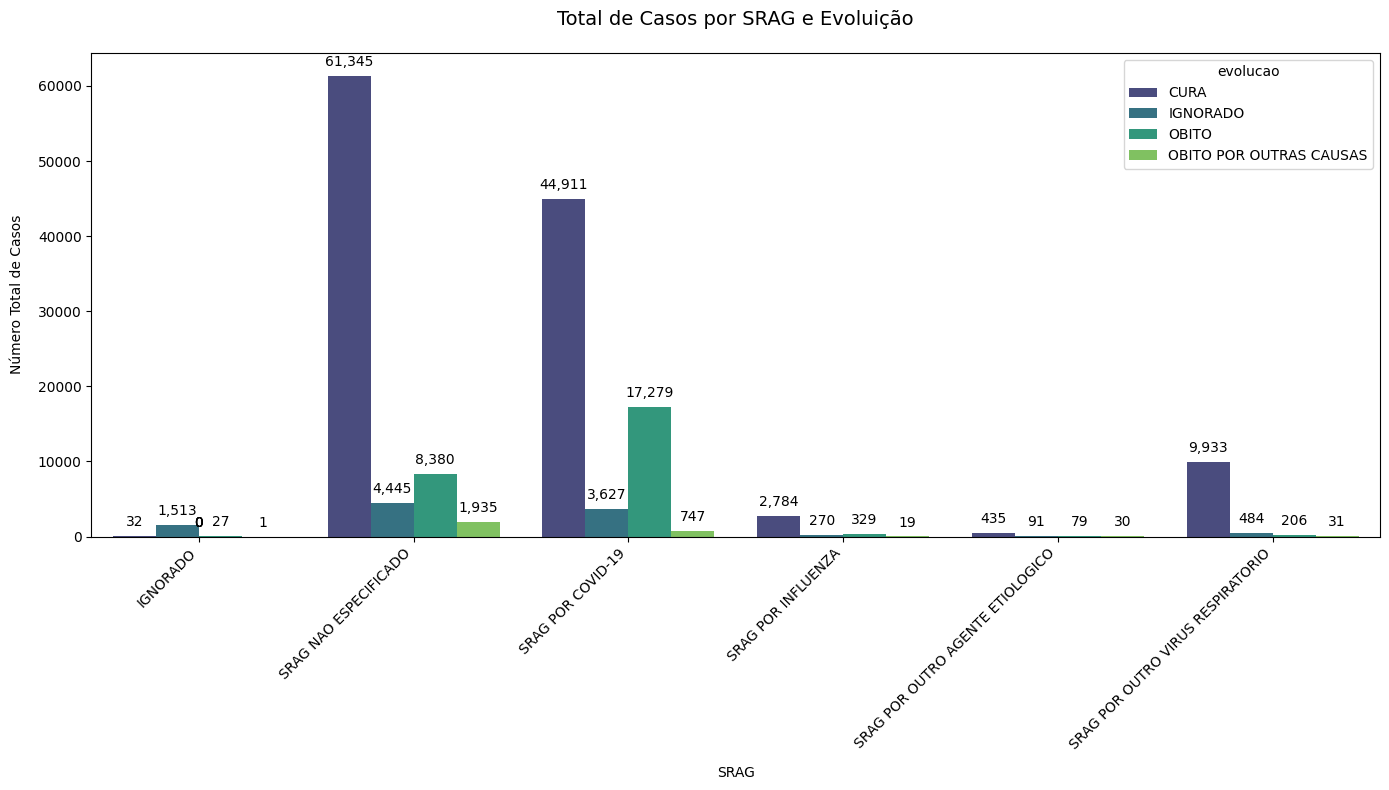

In [17]:
# Gráfico número total de casos por srag e de acordo com a evolução do caso
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, 
                x='srag', 
                y='numero_total_casos',
                palette='viridis',
                hue='evolucao',
                errorbar=None)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Formata com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10,
                color='black')

# Melhorando a visualização
plt.title('Total de Casos por SRAG e Evoluição', pad=20, fontsize=14)
plt.xlabel('SRAG', labelpad=10)
plt.ylabel('Número Total de Casos', labelpad=10)
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

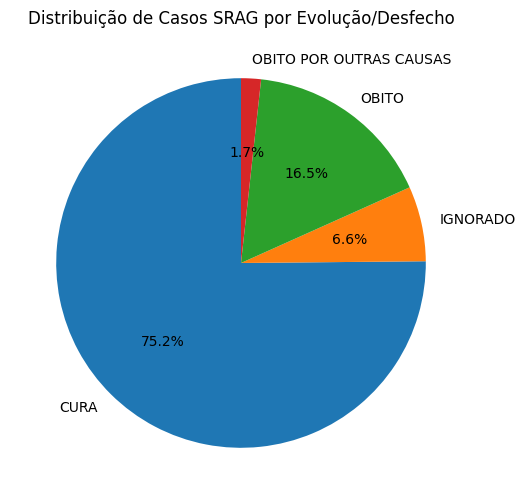

In [18]:
# Agrupar apenas por evolução
df_evol = df.groupby('evolucao')['numero_total_casos'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.pie(df_evol['numero_total_casos'], 
        labels=df_evol['evolucao'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribuição de Casos SRAG por Evolução/Desfecho')
plt.show()